# Data Manipulation of kiva loans data and some additional graphs

* In this notebook I join the externally downloaded Philippines economic indicator data with the philippines subset of kiva loans data on **REGION** field.


* I downloaded the economic indicator data for philippines from [here](http://countrystat.psa.gov.ph/).



* Lets first take a look at the Kiva loans data table.

In [2]:
# supress warnings globally - just for better vieweing of notebook. Warnings were causing too much unwanted clutter to be shown.
options(warn=-1)

suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(repr))
suppressMessages(library(corrplot))
suppressMessages(library(gridExtra))

kiva_loans <- read.csv("kiva_loans.csv", header=T)
kiva_regions <- read.csv("kiva_mpi_region_locations.csv", header=T)

philp_loans <- kiva_loans %>% filter(country == "Philippines")
philp_regions <- kiva_regions %>% filter(country == "Philippines")

head(philp_loans,2)

id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
653092,175,175,Pigs,Agriculture,to buy piglets and feed,PH,Philippines,Liloy-Dela Paz,PHP,126,2014-01-02 00:25:40+00:00,2013-12-12 08:00:00+00:00,2014-01-02 01:42:51+00:00,8,6,,female,irregular,2014-01-02
653149,175,175,Pigs,Agriculture,to purchase feed and vitamins for her pigs,PH,Philippines,"Tanjay, Negros Oriental",PHP,145,2014-01-02 04:18:30+00:00,2013-12-06 08:00:00+00:00,2014-01-02 07:47:28+00:00,8,7,,female,irregular,2014-01-02


* Each row represents a loan given out by Kiva **in Philippines**. It has regional details, loan receiver details etc.. 
* Kiva connects online lenders (like us) to needy people in the world through their partners.
* **Goal of this notebook is to connect the external data to the Philippines subset of the above data frame**

### Note the column 'REGION'. That is the column which we will use as the key to connect the external data.

### Lets check the levels of REGION

In [3]:
length(levels(philp_loans$region))

[1] 12696

### There are 12.5k+ levels for region which is huge. Lets take a look at a sample of those

In [4]:
philp_loans %>% group_by(region) %>% summarise(count = n()) %>% head(10)

region,count
,81
"214 Bonifacio St. Calaocan, Alicia, Isabela",1
26 barrientos st. oroquieta city,1
"Abolo, Amulung, Cagayan",17
"Abra, Santiago City, Isabela",1
"Abuleg, Dinalungan, Aurora",1
"Abut Quezon, Isabela",8
"Abuyog, Leyte",43
"Acad, Zamboanga del Sur",9
"Addalam Jones, Isabela",1


### We can see that the REGION field is actually a concatenation of multiple granular level region fields like County, City, State.

### Let us extract the region field at the top most level of granularity. We will use that in our join because the key in the external table is at that level. I confirmed that the right most field in the concatenation represents such a field. 


### Extracting rightmost field from each REGION field above using RegExp

In [5]:
vec <- c()
philp_loans$loan_region <- as.character(philp_loans$region)
for(i in 1:nrow(philp_loans)){
    vec <- append(vec, sub('.*,\\s*','', philp_loans$loan_region[i]))
}
philp_loans$sub_region <- vec
philp_loans$sub_region[1:20]

[1] "Liloy-Dela Paz"                              
 [2] "Negros Oriental"                             
 [3] "Palawan"                                     
 [4] "Negros Oriental"                             
 [5] "Isabela"                                     
 [6] "Pagadian - Lower Bagong Silang Pagadian City"
 [7] "Palawan"                                     
 [8] "Zamboanga del norte"                         
 [9] "Misamis Occidental"                          
[10] "Zamboanga del Norte"                         
[11] "Negros Oriental"                             
[12] "Plaridel-Cebulin"                            
[13] "Misamis Occidental"                          
[14] "Misamis Occidental"                          
[15] "Misamis Occidental"                          
[16] "Misamis Occidental"                          
[17] "Siquijor"                                    
[18] "Cebu"                                        
[19] "Cebu"                                        
[20] "Misamis Occidental"

### Now let us see how the region field in the external table looks like. Our goal is to do data cleaning and achieve a respectable proportion of match on these keys. 



### To join external table there are two steps

1. We create a 'philippines_regions' table having 2 important region keys. First key is 'provDesc' key which matches 83% with 'sub_region' key in 'philp_loans'. On making this join, the second key 'regDesc' is added to the 'philp_loans' table as a consequence of the join. This second key is very important because that is the common key between loans table and economic indicators external table.

2. After we execute step 1, we simply join the loans data with economic indicators data on the key 'regDesc'


### Step1

#### **Pre-requisite**

* Forming 1 file from 2 files for philippines regions. Files which will be used to bring in the appropriate keys which we will join.
* This is A pre-requisite to step1. This was not been mentioned above so don't get confused. Actual step1 starts from the next to next cell of code.

In [6]:
province = read.csv("philippines_province.csv", header=T)
region = read.csv("philippines_region.csv", header=T)

philippines_regions <- inner_join(province, region, by = "regCode")
philippines_regions$X <- NULL

head(philippines_regions,2)

id.x,psgcCode.x,provDesc,regCode,provCode,id.y,psgcCode.y,regDesc
1,12800000,Ilocos Norte,1,128,1,10000000,Ilocos Region
2,12900000,Ilocos Sur,1,129,1,10000000,Ilocos Region


In [7]:
# Join philip_loans to philippines_regions on "sub_region" == "provDesc"
# Changing name of provDesc to sub_region in the Philippines_regions file
names(philippines_regions)[3] <- "sub_region"

# Left joining to keep all the philip_loans (NAs whereever loan region has no match with external regions file)
philp_loans_new <- left_join(philp_loans, philippines_regions, by = "sub_region")
#prop.table(table(is.na(philp_loans_new$regDesc)))
# currently missing ~ 17% values

head(philp_loans_new,2)

id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,date,loan_region,sub_region,id.x,psgcCode.x,regCode,provCode,id.y,psgcCode.y,regDesc
653092,175,175,Pigs,Agriculture,to buy piglets and feed,PH,Philippines,Liloy-Dela Paz,PHP,...,2014-01-02,Liloy-Dela Paz,Liloy-Dela Paz,NA,NA,NA,NA,NA,NA,NA
653149,175,175,Pigs,Agriculture,to purchase feed and vitamins for her pigs,PH,Philippines,"Tanjay, Negros Oriental",PHP,...,2014-01-02,"Tanjay, Negros Oriental",Negros Oriental,41,74600000,7,746,8,70000000,Central Visayas


### We completed step1 here. New loans table is created with a join on 'sub_region'/'provDesc' (note that 'provDesc' has been renamed as 'sub_region' for the convinience of joining.

### Step2

In [8]:
# importing poverty indicators per region data
philp_poverty_indicators <- read.csv("consolidated_philippines_poverty_data.csv", header=T)
head(philp_poverty_indicators,5)

regDesc,agr_wage_farm_workers_allgender_2015,agr_wage_farm_workers_male_2015,agr_wage_farm_workers_female_2015,avg_annual_total_incm_farm_households_02_03,avg_annual_farm_incm_farm_households_02_03,avg_annual_off_farm_incm_farm_households_02_03,avg_annual_non_farm_incm_farm_households_02_03,avg_annual_other_sources_incm_farm_households_02_03,avg_rural_income_2000,total_emply_2016
Armm,162.89,163.65,103.81,73356,34026,5737,24936,8657,73673,1140
Bicol Region,167.99,169.95,119.52,82988,36579,7348,30381,8680,72626,2331
Cagayan Valley,228.77,232.64,199.98,145809,87353,6909,39894,11653,94212,1482
Calabarzon,230.92,231.45,172.04,143075,64498,8444,48590,21543,NA,5687
Car,206.68,211.04,195.62,127067,71142,9731,37178,9016,95635,765


### A glimpse of economic indicators data. Key is the first column, regDesc.

In [9]:
rm(philp_loans)
philp_loans <- left_join(philp_loans_new, philp_poverty_indicators, by = "regDesc")


rm(philp_loans_new)
philp_loans_new <- philp_loans %>% select(-id.x, -id.y, -psgcCode.y, -psgcCode.x)

head(philp_loans_new,2)

id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,agr_wage_farm_workers_allgender_2015,agr_wage_farm_workers_male_2015,agr_wage_farm_workers_female_2015,avg_annual_total_incm_farm_households_02_03,avg_annual_farm_incm_farm_households_02_03,avg_annual_off_farm_incm_farm_households_02_03,avg_annual_non_farm_incm_farm_households_02_03,avg_annual_other_sources_incm_farm_households_02_03,avg_rural_income_2000,total_emply_2016
653092,175,175,Pigs,Agriculture,to buy piglets and feed,PH,Philippines,Liloy-Dela Paz,PHP,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
653149,175,175,Pigs,Agriculture,to purchase feed and vitamins for her pigs,PH,Philippines,"Tanjay, Negros Oriental",PHP,...,156.17,160.65,150.67,72177,28074,5574,31055,7474,68447,3234


### This is the final table containing all the data we need in the same table

* **We can see that we are missing a lot of data. We are missing the data for the rows which did not find a region match with the external data.**


* **Lets see how many % of the rows we have compromised** *

In [10]:
cat("The proportion of REGION join matches missing due to a bit of unclean data are")
prop.table(table(is.na(philp_loans_new$regDesc)))

The proportion of REGION join matches missing due to a bit of unclean data are


    FALSE      TRUE 
0.8237171 0.1762829 

* We are missing new region values for **17.6%** Philippines loans.



* Lets delete these rows for further analysis.

In [11]:
completeFun <- function(data, desiredCols) {
  completeVec <- complete.cases(data[, desiredCols])
  return(data[completeVec, ])
}

philp_data <- completeFun(philp_loans_new, "regDesc")

* Now let us dig deep into the FEMALE-AGRICULTURE segment in Philippines



* Correlations of different poverty metrics and loan features using 'corrplot' package



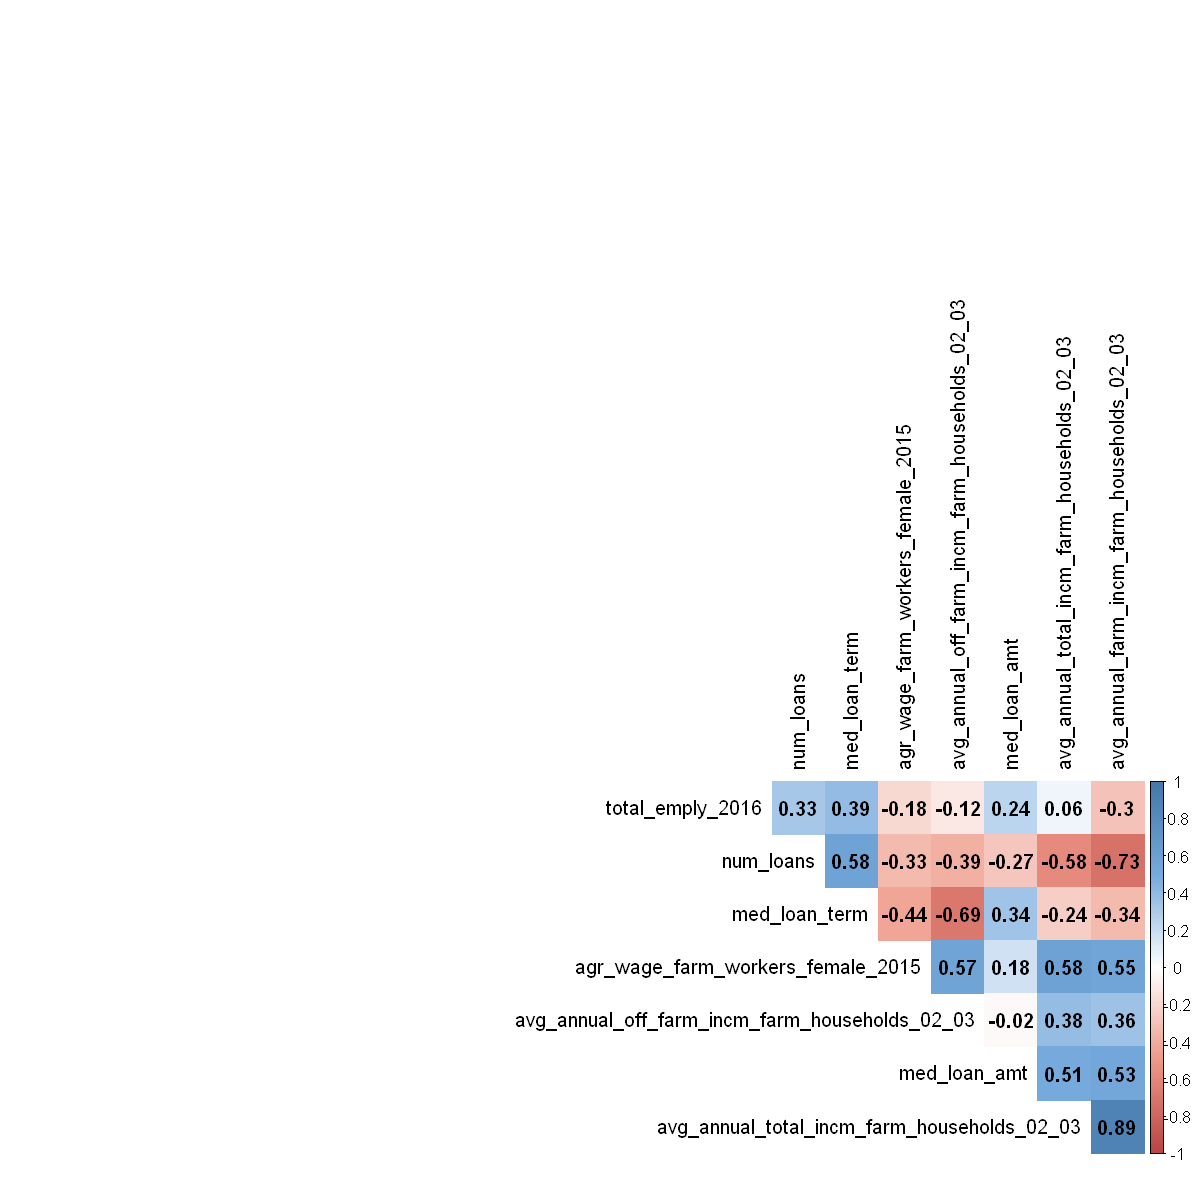

In [12]:
philp_data$gender <- if_else((philp_data$borrower_genders == "male"), "male","female")

# Segment: Female-Agriculture


female_agr_summary <- philp_data %>% filter(gender == "female" & sector == "Agriculture") %>%
         group_by(regDesc) %>% summarise(num_loans = n_distinct(id),
                                            med_loan_amt = median(loan_amount),
                                            med_loan_term = median(term_in_months),
                                              agr_wage_farm_workers_female_2015 = mean(agr_wage_farm_workers_female_2015),
                                              avg_annual_total_incm_farm_households_02_03 = mean(avg_annual_total_incm_farm_households_02_03),
                                              avg_annual_farm_incm_farm_households_02_03 = mean(avg_annual_farm_incm_farm_households_02_03),
                                              avg_annual_off_farm_incm_farm_households_02_03 = mean(avg_annual_off_farm_incm_farm_households_02_03),
                                              avg_rural_income_2000 = mean(avg_rural_income_2000),
                                              total_emply_2016 = mean(total_emply_2016))

corr_1 = cor(female_agr_summary[,c(2:8,10)])

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

options(repr.plot.width=10, repr.plot.height=10)

corrplot(corr_1, method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=90, #Text label color and rotation
         # Combine with significance
          sig.level = 0.01, insig = "blank", 
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

options(repr.plot.width=7, repr.plot.height=7)

* **Following are the variables**

1) agr_wage_farm_workers_allgender_2015 - Agriculture Wage Rates of Farm Workers (All Gender) in 2015 - UNIT: pesos

2) agr_wage_farm_workers_male_2015 - Similar to above for males - UNIT: pesos

3) agr_wage_farm_workers_female_2015 - Similar to above for females - UNIT: pesos

4) avg_annual_total_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

5) avg_annual_farm_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

6) avg_annual_off_farm_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

7) avg_annual_non_farm_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

8) avg_annual_other_sources_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

9) avg_rural_income_2000 - Average rural income - UNIT: pesos

10) total_emply_2016 - Total employment 2016 - UNIT: thousand persons


* We can see **Number of loans & Loan terms have negative correlation with all the income variables** implying as the number of loans and/or loan_terms in a region go up, the income indicators are coming down. This is intuitive in a sense that poor people are the ones who take more and longer loans.


* **Median loan amount on the other hand as positive correlation with most of the income indicators** implying that as the median loan amount goes up in a region, the income indicators are seen to be on an increase as well. This is also intuitive.



* **The negative correlation of number of loans with farm income is more in magnitude than total income or off farm income in farm households**. So KIVA can also prioritize loans based on different incomes of a particular person. If lets say a female is a farmer in a poor area with a very low farm income, then the loan to that female can be prioritized over a loan request of a female in a rich area having more farm income.


#### Q) Which region is the poorest w.r.t the income indicators we have?

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

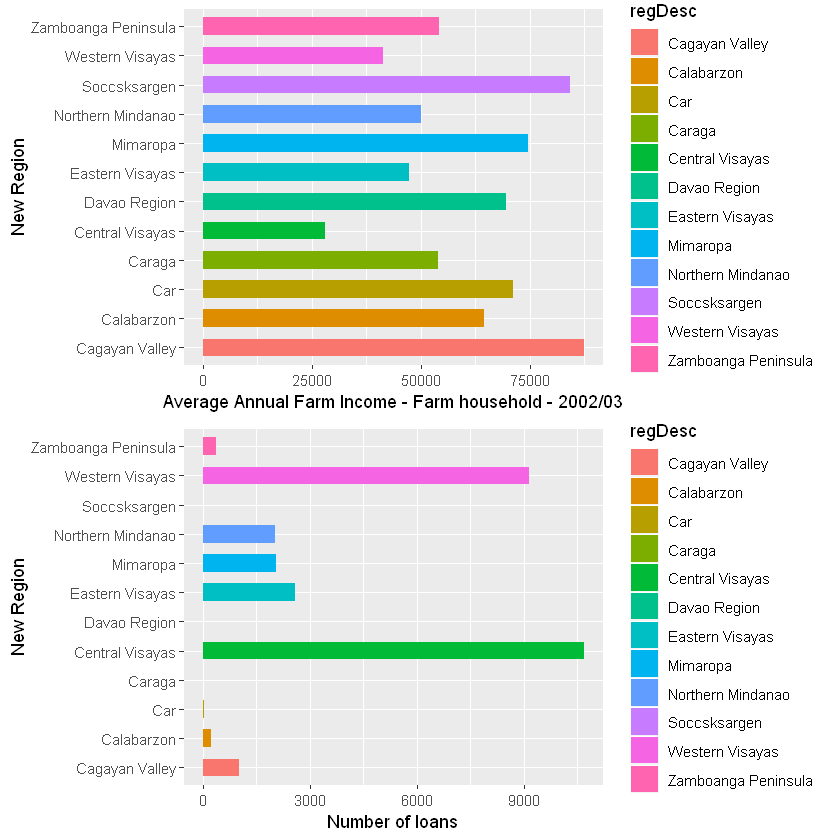

In [13]:
plt_5 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = avg_annual_farm_incm_farm_households_02_03)) +
  geom_bar(aes(fill = regDesc), stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Average Annual Farm Income - Farm household - 2002/03") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
    coord_flip() + theme_grey()

plt_6 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = num_loans)) +
  geom_bar(aes(fill = regDesc),stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Number of loans") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
 coord_flip() + theme_grey()

grid_1 <- grid.arrange(plt_5, plt_6, nrow = 2, ncol=1)
grid_1

* Among this segment (Female-Agriculture), **loans should be prioritized in CENTRAL & WESTERN VISAYAS regions because clearly they are not doing too good with respect to Average Annual Farm Income** metrics in pesos and are also taking **high number of loans** indicating a more needy section of people inhabiting in these regions.



* Agriculture females in regions like **Soccsksargen, Cagayan Valley, Davao, CAR** take less loans or rather their might be less population from this segment their in the first place. These regions where the loans are less do well though with respect to Farm incomes. So Farming/Agriculture families staying in these places can be assumed to be richer.

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

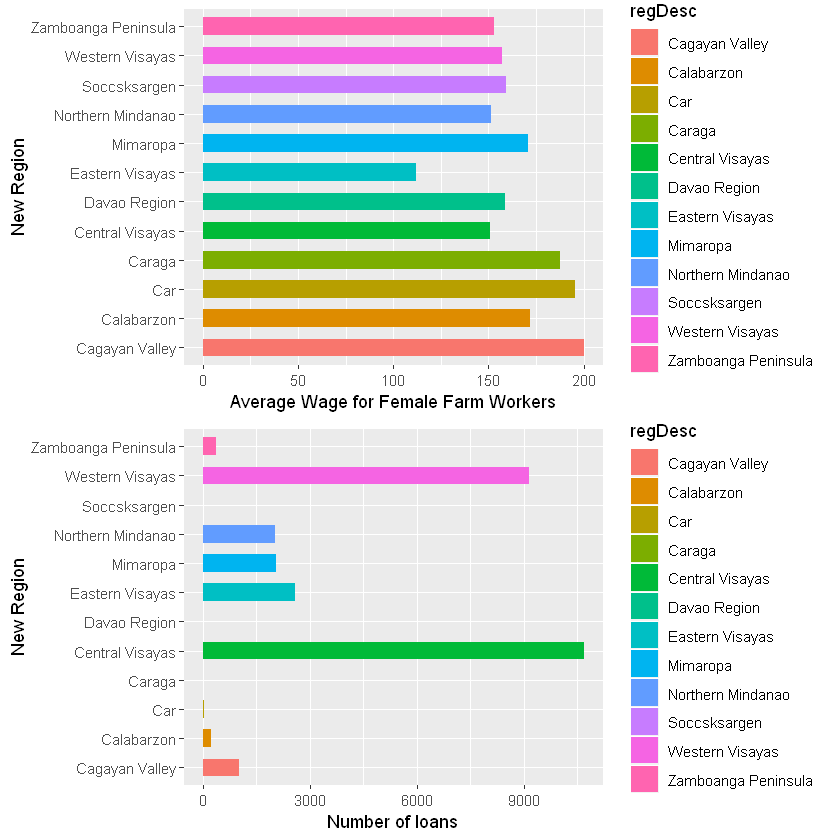

In [14]:
plt_7 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = agr_wage_farm_workers_female_2015)) +
  geom_bar(aes(fill = regDesc), stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Average Wage for Female Farm Workers") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
    coord_flip() + theme_grey()

plt_8 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = num_loans)) +
  geom_bar(aes(fill = regDesc),stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Number of loans") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
 coord_flip() + theme_grey()

grid_1 <- grid.arrange(plt_7, plt_8, nrow = 2, ncol=1)
grid_1

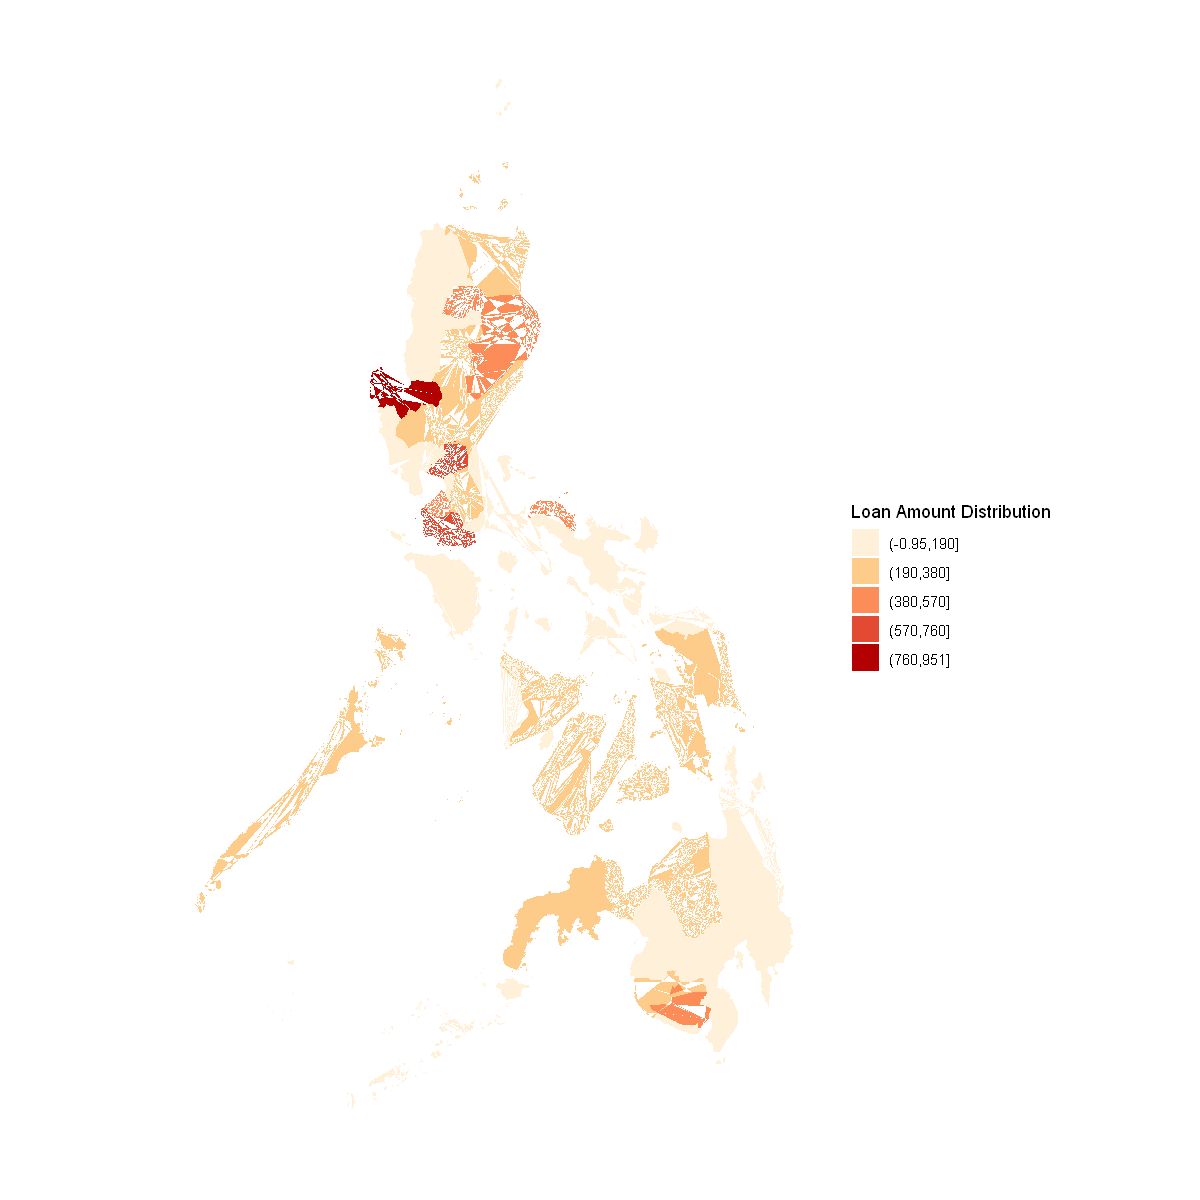

In [16]:
library(ggplot2)
library(rgdal)
library(maptools)
library(rgeos)
library(dplyr)

ph.adm1.spdf <- readRDS("PHL_adm2.rds")
ph.adm1.df <- fortify(ph.adm1.spdf, region = "NAME_1")

phadmunique = unique(ph.adm1.df$id)
subregunique = unique(philp_loans$sub_region)
common_regions = intersect(phadmunique, subregunique)

gb_loan_amt_ph <-  philp_loans %>% 
      filter(sub_region %in% common_regions) %>%
        group_by(sub_region) %>% summarise(loan_amt_median = median(loan_amount))

gb_loan_amt_ph <- data.frame(gb_loan_amt_ph)
names(gb_loan_amt_ph)[1] = "id"

ph.adm1.df <- merge(ph.adm1.df, gb_loan_amt_ph, by.y = 'id', all.x = TRUE)
ph.adm1.df$loan_amt_median[is.na(ph.adm1.df$loan_amt_median)] <- 0

ph.adm1.centroids.df <- data.frame(long = coordinates(ph.adm1.spdf)[, 1], 
                                   lat = coordinates(ph.adm1.spdf)[, 2]) 

# Get names and id numbers corresponding to administrative areas
ph.adm1.centroids.df[, 'ID_1'] <- ph.adm1.spdf@data[,'ID_1']
ph.adm1.centroids.df[, 'NAME_1'] <- ph.adm1.spdf@data[,'NAME_1']


options(repr.plot.width=10, repr.plot.height=10)
p <- ggplot(ph.adm1.df, aes(x = long, y = lat, group = group)) + geom_polygon(aes(fill = cut(loan_amt_median,5))) +
 # geom_text(data = ph.adm1.centroids.df, aes(label = NAME_1, x = long, y = lat, group = NAME_1), size = 1) + 
  labs(x=" ", y=" ") + 
  theme_bw() + scale_fill_brewer('Loan Amount Distribution', palette  = 'OrRd') + 
  coord_map() + 
  theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) + 
  theme(axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank()) + 
  theme(panel.border = element_blank())

print(p)